In [3]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

Load data

In [4]:
train = fetch_20newsgroups(subset='train', shuffle=True)
test = fetch_20newsgroups(subset='test', shuffle=True)
# with open('20_newsgroups_train.pickle', 'rb') as f:
#     train = pickle.load(f)
# with open('20_newsgroups_test.pickle', 'rb') as f:
#     test = pickle.load(f)
print(dir(train))
print(len(train.data))
print("Target names:", train.target_names)
print("------------------------------------")
print("Label:", train.target_names[train.target[0]])
print("Text:", train.data[0][:250])
print("------------------------------------")

['DESCR', 'data', 'filenames', 'target', 'target_names']
11314
Target names: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
------------------------------------
Label: rec.autos
Text: From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the ot
------------------------------------


Stemming

In [5]:
# import nltk

# nltk.data.path.append('nltk_data')
# from nltk.corpus import stopwords

# stop_words = set(stopwords.words('english'))

stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

Pipelines

In [6]:
pipelines = {
    "DTC": Pipeline(
        [
            ("vect", CountVectorizer()),
            ("tfidf", TfidfTransformer()),
            ("dtc", DecisionTreeClassifier()),
        ]
    ),
    "DTC stop words": Pipeline(
        [
            ("vect", CountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("dtc", DecisionTreeClassifier()),
        ]
    ),
    "DTC stemming": Pipeline(
        [
            ("vect", StemmedCountVectorizer()),
            ("tfidf", TfidfTransformer()),
            ("dtc", DecisionTreeClassifier()),
        ]
    ),
    "DTC stop words + stemming": Pipeline(
        [
            ("vect", StemmedCountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("dtc", DecisionTreeClassifier()),
        ]
    ),
    "RFC": Pipeline(
        [
            ("vect", CountVectorizer()),
            ("tfidf", TfidfTransformer()),
            ("dtc", RandomForestClassifier()),
        ]
    ),
    "RFC stop words": Pipeline(
        [
            ("vect", CountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("dtc", RandomForestClassifier()),
        ]
    ),
    "RFC stemming": Pipeline(
        [
            ("vect", StemmedCountVectorizer()),
            ("tfidf", TfidfTransformer()),
            ("dtc", RandomForestClassifier()),
        ]
    ),
    "RFC stop words + stemming": Pipeline(
        [
            ("vect", StemmedCountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("dtc", RandomForestClassifier()),
        ]
    ),
}

In [7]:
for key, pipeline in pipelines.items():
    pipeline = pipeline.fit(train.data, train.target)
    predicted = pipeline.predict(test.data)
    print(f"{key}: {np.mean(predicted == test.target)}")

DTC: 0.5566914498141264
DTC stop words: 0.573951141795008
DTC stemming: 0.548194370685077
DTC stop words + stemming: 0.5669144981412639
RFC: 0.7578332448220924
RFC stop words: 0.7900955921402018
RFC stemming: 0.762745618693574
RFC stop words + stemming: 0.7805363781200212


It seems that stemming and removing stopwords helps

In [8]:
models = {
    "DTC": Pipeline(
        [
            ("vect", StemmedCountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("dtc", DecisionTreeClassifier()),
        ]
    ),
    "RFC": Pipeline(
        [
            ("vect", StemmedCountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("dtc", RandomForestClassifier()),
        ]
    ),
    "Naive Bayes": Pipeline(
        [
            ("vect", StemmedCountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("nb", MultinomialNB()),
        ]
    ),
    "SVM": Pipeline(
        [
            ("vect", StemmedCountVectorizer(stop_words="english")),
            ("tfidf", TfidfTransformer()),
            ("svm", SVC(kernel="linear")),
        ]
    ),
}

Cross validation

DTC:
	mean: 0.6527,	std: 0.0140
RFC:
	mean: 0.8553,	std: 0.0046
Naive Bayes:
	mean: 0.8751,	std: 0.0065
SVM:
	mean: 0.9166,	std: 0.0032


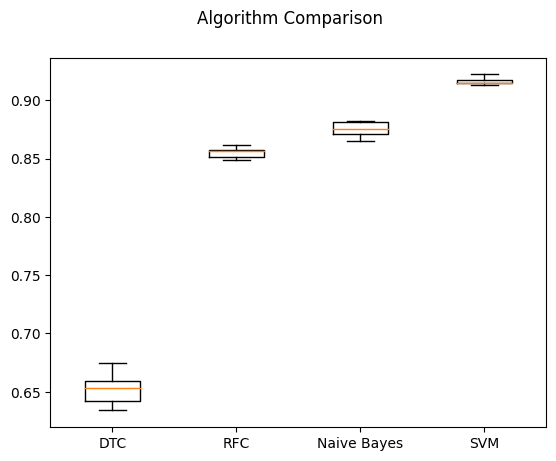

In [9]:
results = []
names = []
scoring = "accuracy"

for name, model in models.items():
    kfold = model_selection.KFold(n_splits=5)
    cv_results = model_selection.cross_val_score(model, train.data, train.target, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"\033[94m{name}\033[0m:\n\tmean: {cv_results.mean():.4f},\tstd: {cv_results.std():.4f}")

fig = plt.figure()
fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()